In [37]:
# Please note that Colorization GPU training results are included in Colorization (Includes GPU Computing) Jupyter notebook

In [38]:
#GPUs were used to achieve best Colorization and Transfer Learning results

In [7]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from random import shuffle
import PIL
from PIL import Image
import copy
import cv2
import glob
import cv2
import os 
from os import path
from skimage.color import lab2rgb
torch.set_default_tensor_type('torch.FloatTensor')
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ConvTranspose2d
from torch.optim import Adam, SGD
from math import log10, sqrt
import numpy as np
from skimage.metrics import structural_similarity
import argparse
import imutils
import time

In [3]:
#Loading data function
images = []
def load_images_from_folder(folder):
    for filename in os.listdir(folder):
        #print(filename)
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            #print('hi')
            images.append((img,filename))
    return images

In [4]:
#LAB images
images = load_images_from_folder("./face_images")
L_images = []
ab_images= []
for img,filename in images:
    imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(imageLAB)
    L=np.array(L,dtype=np.float32)
    L=L[np.newaxis,:,:]
    a=np.array(a,dtype=np.float32)
    b=np.array(b,dtype=np.float32)
    ab=[]
    ab.append(a)
    ab.append(b)
    ab=np.array(ab)
    ab_images.append(torch.tensor(ab))
    L_images.append(torch.tensor(L))

In [5]:
#Train & Test data
train_percentage=90
train_size=int((975/100)*train_percentage)
test_size=975-train_size
all_indices=np.arange(0,975)
np.random.shuffle(all_indices)
train_L=[]
train_ab=[]
test_L=[]
test_ab=[]
for i in all_indices[:train_size]:
    train_L.append(L_images[i])
    train_ab.append(ab_images[i])
for i in all_indices[train_size:]:
    test_L.append(L_images[i])
    test_ab.append(ab_images[i])
train_L=torch.stack(train_L, dim=0)
train_ab=torch.stack(train_ab, dim=0)
test_L=torch.stack(test_L, dim=0)
test_ab=torch.stack(test_ab, dim=0)

In [6]:
class Convnet(nn.Module):   
    def __init__(self):
        super(Convnet, self).__init__()

        self.convolution_layers = Sequential(
            Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.deconvolution_layers = Sequential(
            ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            nn.ReLU(),
            ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            nn.ReLU(),
            ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            nn.ReLU(),
            ConvTranspose2d(8, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            nn.ReLU()
        )


    # Defining the forward pass    
    def forward(self, x):
        x = self.convolution_layers(x)
        x = self.deconvolution_layers(x)
        return x

# Training with CPU

In [12]:
model=torch.load('./colorizer.pkl')
device="cpu"
print("Device", device)


batch_size = 10
num_epochs = 8
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)
cpu_time=[]
training_start_time = time.time()
for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    
    print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))
    
    cpu_time.append(time.time()-training_start_time)

Device cpu
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 8
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Bat

In [13]:
cpu_time

[73.6412398815155,
 148.5677888393402,
 222.3267719745636,
 296.60596346855164,
 370.39390897750854,
 444.7990026473999,
 518.5712730884552,
 592.2489430904388]

# Training with GPU

In [31]:
#torch command for enabling cuda
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [20]:
#Making sure Cuda is available
print(torch.cuda.is_available())

True


In [24]:
#Printing the CuDNN version
print(torch.backends.cudnn.version())

7605


In [32]:
#Carrying out garbage collection for preventing out of memory error
import gc
gc.collect()
torch.cuda.empty_cache()

In [33]:
model=torch.load('./colorizer.pkl')
print("Device", device)


batch_size = 10
num_epochs = 8
N=train_size
learning_rate = 0.01
batches = int(N/batch_size)
model = model.float()
model.to(device)

train_data=copy.deepcopy(train_L)
train_data=train_data/255
train_data = train_data.to(device)
print("Printing train data shape")
print(train_data.shape)
train_ab = train_ab.to(device)
print("Printing train ab shape")
print(train_ab.shape)
test_data = copy.deepcopy(test_L)
test_data = test_data.to(device)
test_data=test_data/255
print("Printing test data shape")
print(test_data.shape)
test_ab = test_ab.to(device)
print("Printing test ab shape")
print(test_ab.shape)


error = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("batch_size:",batch_size)
print('num_epochs:',num_epochs)
print("learning_rate:",learning_rate)
print("batches:",batches)
print("optimizer:",'Adam')
print("Loss function:","MSELoss")
print(model)

loss_hist = np.zeros(num_epochs)
loss_test_hist = np.zeros(num_epochs)
gpu_time=[]
training_start_time = time.time()
for epoch in range(num_epochs):
    for index in range(batches):
        patterns = train_data[index*batch_size:(index+1)*batch_size]
        labels = train_ab[index*batch_size:(index+1)*batch_size]
        
        #print("printing all labels shape")
        #print(labels.shape)
        # Forward pass 
        outputs = model(patterns)
        loss = error(outputs, labels)
        

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        # Optimizing the parameters
        optimizer.step()
        
        #Saving the loss for visualization
        loss_hist[epoch] += loss.data
        

    #test_total
    patterns = test_data
    labels = test_ab
    outputs = model(patterns)
    is_correct = torch.subtract(labels,outputs)
    loss_test_hist[epoch] += (is_correct.sum()*is_correct.sum())/test_size

    
    print("Epoch: {}, Loss: {:.7f}, Testing Loss: {:.3f}".format( 
                        epoch, loss_hist[epoch], loss_test_hist[epoch]))
    
    gpu_time.append(time.time()-training_start_time)

Device cuda:3
Printing train data shape
torch.Size([877, 1, 128, 128])
Printing train ab shape
torch.Size([877, 2, 128, 128])
Printing test data shape
torch.Size([98, 1, 128, 128])
Printing test ab shape
torch.Size([98, 2, 128, 128])
batch_size: 10
num_epochs: 8
learning_rate: 0.01
batches: 87
optimizer: Adam
Loss function: MSELoss
Convnet(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): 

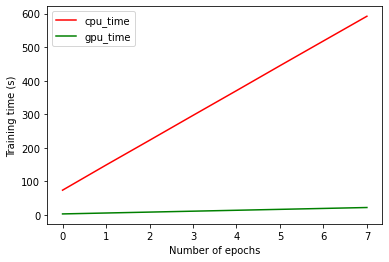

In [35]:
plt.plot(cpu_time,c='r')
plt.plot(gpu_time,c='g')
plt.xlabel('Number of epochs')
plt.ylabel('Training time (s)')
plt.legend(['cpu_time','gpu_time'])
plt.show()

We can clearly see that training on GPU is significantly faster than training on CPU

# Speed up gained with GPU (Extra credit)

In [36]:
print("Speed up gained with GPU is {}".format(cpu_time[-1]/gpu_time[-1]))

Speed up gained with GPU is 26.968080620495375


Training with GPU is approximately 27 times faster than training with CPU